In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import numpy as np
import string
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [30]:
def read_text(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text
def to_lines(text):
    sents = text.strip().split('\n')
    return sents
text_hin=read_text('/content/drive/MyDrive/IITB.en-hi.hi')
text_eng=read_text('/content/drive/MyDrive/IITB.en-hi.en')
data_hin=to_lines(text_hin)#splitting into lines
data_eng=to_lines(text_eng)
#converting sentences to dataframe
df_hin=pd.DataFrame(data_hin)
df_eng=pd.DataFrame(data_eng)

In [31]:
df = pd.DataFrame(list(zip(data_eng,data_hin)))
df.head(20)
df.to_csv('/content/drive/MyDrive/dataset_tdl.csv')

In [32]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
import os
import re

In [33]:
data = pd.read_csv("/content/drive/MyDrive/dataset_tdl.csv")
data = data.head(25000)
english_sentences = data["0"]
hindi_sentences = data["1"]

In [34]:
num_words = 10000
oov_token = '<UNK>'
english_vocab_size = num_words + 1
hindi_vocab_size = num_words + 1
MAX_WORDS_IN_A_SENTENCE = 16
test_ratio = 0.2
BATCH_SIZE = 512
embedding_dim = 64
hidden_units = 1024
learning_rate = 0.006
epochs = 100

In [35]:
def preprocess_sentence(sen, is_english):
	if (type(sen) != str):
		return ''
	sen = sen.strip('.')
	
	# insert space between words and punctuations
	sen = re.sub(r"([?.!,¿;।])", r" \1 ", sen)
	sen = re.sub(r'[" "]+', " ", sen)
	
	# For english, replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
	if(is_english == True):
		sen = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sen)
		sen = sen.lower()
	
	sen = sen.strip()
	sen = 'sentencestart ' + sen + ' sentenceend'
	
	sen = ' '.join(sen.split())
	return sen

In [36]:
# Loop through each datapoint having english and hindi sentence
processed_e_sentences = []
processed_h_sentences = []
for (e_sen, h_sen) in zip(english_sentences, hindi_sentences):
	processed_e_sen = preprocess_sentence(e_sen, True)
	processed_h_sen = preprocess_sentence(h_sen, False)
	if(processed_e_sen == '' or processed_h_sen == '' or processed_e_sen.count(' ') >  (MAX_WORDS_IN_A_SENTENCE-1) or processed_h_sen.count(' ') > (MAX_WORDS_IN_A_SENTENCE-1)):
		continue
	
	processed_e_sentences.append(processed_e_sen)
	processed_h_sentences.append(processed_h_sen)

print("Sentence examples: ")
print(processed_e_sentences[0])
print(processed_h_sentences[0])
print("Length of English processed sentences: " + str(len(processed_e_sentences)))
print("Length of Hindi processed sentences: " + str(len(processed_h_sentences)))

Sentence examples: 
sentencestart give your application an accessibility workout sentenceend
sentencestart अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें sentenceend
Length of English processed sentences: 24178
Length of Hindi processed sentences: 24178


In [37]:
def tokenize_sentences(processed_sentences, num_words, oov_token):
	tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
	tokenizer.fit_on_texts(processed_sentences)
	word_index = tokenizer.word_index
	sequences = tokenizer.texts_to_sequences(processed_sentences)
	sequences = pad_sequences(sequences, padding = 'post')
	return word_index, sequences, tokenizer

english_word_index, english_sequences, english_tokenizer = tokenize_sentences(processed_e_sentences, num_words, oov_token)
hindi_word_index, hindi_sequences, hindi_tokenizer = tokenize_sentences(processed_h_sentences, num_words, oov_token)


In [38]:
# split into traning and validation set
english_train_sequences, english_val_sequences, hindi_train_sequences, hindi_val_sequences = train_test_split(english_sequences, hindi_sequences, test_size = test_ratio)
BUFFER_SIZE = len(english_train_sequences)


In [39]:
# Batching the training set
dataset = tf.data.Dataset.from_tensor_slices((english_train_sequences, hindi_train_sequences)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
print("No. of batches: " + str(len(list(dataset.as_numpy_iterator()))))


No. of batches: 37


In [40]:
class Encoder(tf.keras.Model):
	
	def __init__(self, english_vocab_size, embedding_dim, hidden_units):
		super(Encoder, self).__init__()
		self.embedding = tf.keras.layers.Embedding(english_vocab_size, embedding_dim)
		self.gru = tf.keras.layers.GRU(hidden_units, return_sequences = True, return_state = True)
		
	def call(self, input_sequence):
		x = self.embedding(input_sequence)
		encoder_sequence_output, final_encoder_state = self.gru(x)
		#	Dimensions of encoder_sequence_output => (BATCH_SIZE, MAX_WORDS_IN_A_SENTENCE, hidden_units)
		#	Dimensions of final_encoder_state => (BATCH_SIZE, hidden_units)
		return encoder_sequence_output, final_encoder_state


In [41]:
# initialize our encoder
encoder = Encoder(english_vocab_size, embedding_dim, hidden_units)

class BasicDotProductAttention(tf.keras.layers.Layer):
	def __init__(self):
		super(BasicDotProductAttention, self).__init__()
		
	def call(self, decoder_hidden_state, encoder_outputs):
		#	Dimensions of decoder_hidden_state => (BATCH_SIZE, hidden_units)
		#	Dimensions of encoder_outputs => (BATCH_SIZE, MAX_WORDS_IN_A_SENTENCE, hidden_units)

		decoder_hidden_state_with_time_axis = tf.expand_dims(decoder_hidden_state, 2)
		#	Dimensions of decoder_hidden_state_with_time_axis => (BATCH_SIZE, hidden_units, 1)
		attention_scores = tf.matmul(encoder_outputs, decoder_hidden_state_with_time_axis)
		#	Dimensions of attention_scores => (BATCH_SIZE, MAX_WORDS_IN_A_SENTENCE, 1)
		attention_scores = tf.nn.softmax(attention_scores, axis = 1)
		weighted_sum_of_encoder_outputs = tf.reduce_sum(encoder_outputs * attention_scores, axis = 1)
		#	Dimensions of weighted_sum_of_encoder_outputs => (BATCH_SIZE, hidden_units)

		return weighted_sum_of_encoder_outputs, attention_scores


In [42]:
class Decoder(tf.keras.Model):
	def __init__(self, hindi_vocab_size, embedding_dim, hidden_units):
		super(Decoder, self).__init__()
		self.embedding = tf.keras.layers.Embedding(hindi_vocab_size, embedding_dim)
		self.gru = tf.keras.layers.GRU(hidden_units, return_state = True)
		self.word_probability_layer = tf.keras.layers.Dense(hindi_vocab_size, activation = 'softmax')
		self.attention_layer = BasicDotProductAttention()
		
	def call(self, decoder_input, decoder_hidden, encoder_sequence_output):
		
		x = self.embedding(decoder_input)
		#	Dimensions of x => (BATCH_SIZE, embedding_dim)
		weighted_sum_of_encoder_outputs, attention_scores = self.attention_layer(decoder_hidden, encoder_sequence_output)
		#	Dimensions of weighted_sum_of_encoder_outputs => (BATCH_SIZE, hidden_units)
		x = tf.concat([weighted_sum_of_encoder_outputs, x], axis = -1)
		x = tf.expand_dims(x, 1)
		#	Dimensions of x => (BATCH_SIZE, 1, hidden_units + embedding_dim)
		decoder_output, decoder_state = self.gru(x)
		#	Dimensions of decoder_output => (BATCH_SIZE, hidden_units)
		word_probability = self.word_probability_layer(decoder_output)
		#	Dimensions of word_probability => (BATCH_SIZE, hindi_vocab_size)
		return word_probability, decoder_state, attention_scores

In [43]:
# initialize our decoder
decoder = Decoder(hindi_vocab_size, embedding_dim, hidden_units)


optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
def loss_function(actual_words, predicted_words_probability):
	loss = loss_object(actual_words, predicted_words_probability)
	mask = tf.where(actual_words > 0, 1.0, 0.0)
	return tf.reduce_mean(mask * loss)

In [44]:
def train_step(english_sequences, hindi_sequences):
	loss = 0
	with tf.GradientTape() as tape:
		encoder_sequence_output, encoder_hidden = encoder(english_sequences)
		decoder_hidden = encoder_hidden
		decoder_input = hindi_sequences[:, 0]
		for i in range(1, hindi_sequences.shape[1]):
			predicted_words_probability, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_sequence_output)
			actual_words = hindi_sequences[:, i]
			# if all the sentences in batch are completed
			if np.count_nonzero(actual_words) == 0:
				break
			loss += loss_function(actual_words, predicted_words_probability)

			decoder_input = actual_words

	variables = encoder.trainable_variables + decoder.trainable_variables
	gradients = tape.gradient(loss, variables)
	optimizer.apply_gradients(zip(gradients, variables))
	return loss.numpy()




Epoch No.: 0 Time: 32.08095383644104
Epoch No.: 1 Time: 30.827366828918457
Epoch No.: 2 Time: 31.16741704940796
Epoch No.: 3 Time: 30.794485330581665
Epoch No.: 4 Time: 30.913137197494507
Epoch No.: 5 Time: 30.466742753982544
Epoch No.: 6 Time: 30.75901484489441
Epoch No.: 7 Time: 40.95297312736511
Epoch No.: 8 Time: 30.600569486618042
Epoch No.: 9 Time: 30.606211185455322
Epoch No.: 10 Time: 30.73444414138794
Epoch No.: 11 Time: 30.485220432281494
Epoch No.: 12 Time: 30.553207397460938
Epoch No.: 13 Time: 30.632867336273193
Epoch No.: 14 Time: 30.57555103302002
Epoch No.: 15 Time: 30.59520959854126
Epoch No.: 16 Time: 31.099153757095337
Epoch No.: 17 Time: 30.682854652404785
Epoch No.: 18 Time: 30.60259485244751
Epoch No.: 19 Time: 30.715871572494507
Epoch No.: 20 Time: 30.53346037864685
Epoch No.: 21 Time: 30.495699644088745
Epoch No.: 22 Time: 30.49625515937805
Epoch No.: 23 Time: 31.005390405654907
Epoch No.: 24 Time: 30.401612281799316
Epoch No.: 25 Time: 30.66117548942566
Epoch N

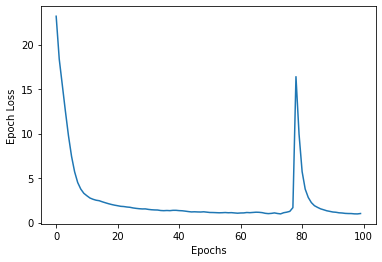

In [45]:
all_epoch_losses = []
training_start_time = time.time()
for epoch in range(epochs):
	epoch_loss = []
	start_time = time.time()
	for(batch, (english_sequences, hindi_sequences)) in enumerate(dataset):
		batch_loss = train_step(english_sequences, hindi_sequences)
		epoch_loss.append(batch_loss)

	all_epoch_losses.append(sum(epoch_loss)/len(epoch_loss))
	print("Epoch No.: " + str(epoch) + " Time: " + str(time.time()-start_time))

print("All Epoch Losses: " + str(all_epoch_losses))
print("Total time in training: " + str(time.time() - training_start_time))

plt.plot(all_epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Epoch Loss")
plt.show()

In [46]:
def get_sentence_from_sequences(sequences, tokenizer):
	return tokenizer.sequences_to_texts(sequences)


In [47]:
# Testing
def translate_sentence(sentence):
	sentence = preprocess_sentence(sentence, True)
	sequence = english_tokenizer.texts_to_sequences([sentence])[0]
	sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen = MAX_WORDS_IN_A_SENTENCE, padding = 'post')
	encoder_input = tf.convert_to_tensor(sequence)
	encoder_sequence_output, encoder_hidden = encoder(encoder_input)
	decoder_input = tf.convert_to_tensor([hindi_word_index['sentencestart']])
	decoder_hidden = encoder_hidden
	
	sentence_end_word_id = hindi_word_index['sentenceend']
	hindi_sequence = []
	for i in range(MAX_WORDS_IN_A_SENTENCE*2):
		predicted_words_probability, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_sequence_output)
		# taking the word with maximum probability
		predicted_word_id = tf.argmax(predicted_words_probability[0]).numpy()
		hindi_sequence.append(predicted_word_id)
		# if the word 'sentenceend' is predicted, exit the loop
		if predicted_word_id == sentence_end_word_id:
			break
		decoder_input = tf.convert_to_tensor([predicted_word_id])
	print(sentence)
	return get_sentence_from_sequences([hindi_sequence], hindi_tokenizer)


In [61]:
# print translated sentence
print(translate_sentence("interactive console for manipulating currently selected accessible"))

sentencestart interactive console for manipulating currently selected accessible sentenceend
['इस समय चुने गए एक्सेसेबेल से काम लेने के लिए अंतर्क्रियात्मक कन्सोल sentenceend']
